In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

    
def to_p(ds,p):
    return ds.assign(p=p).swap_dims({'z': 'p'})


plt.rc('figure', dpi=100)

I computed the forcings using the SAM model, by loading in the initial conditions, and the running 30 minutes forward to compute the tendency. SAM was run with microphysics, radiation, and the boundary layer scheme, so this tendency includes all these effects.

In [2]:
tend_path = "../data/processed/forcings.nc"
input_path = "../data/processed/inputs.nc"
dry_path = "../data/processed/tend_dry.nc"

Maybe these problems are coming from the microphysics or radiation.

In [3]:
ds = xr.open_dataset(dry_path, chunks={'time': 100})
p = ds.p[0].drop('time')

ds = to_p(ds, p)

In [4]:
ds1 = ds.isel(time=slice(0, None, 2))
ds2 = ds.isel(time=slice(1, None, 2))

dt = (ds2.time.values-ds1.time.values)[0]

x = xr.concat([ds1, ds2.assign_coords(time=ds1.time)], dim='step').assign(dt=dt)


FSL = (x.TABS[1] - x.TABS[0])/x.dt
FQV = (x.QV[1] - x.QV[0])/x.dt

FSL.persist()

<xarray.DataArray (time: 640, p: 34, y: 64, x: 128)>
dask.array<shape=(640, 34, 64, 128), dtype=float64, chunksize=(50, 34, 64, 128)>
Coordinates:
  * x        (x) float32 0.0 160000.0 320000.0 480000.0 640000.0 800000.0 ...
  * y        (y) float32 0.0 160000.0 320000.0 480000.0 640000.0 800000.0 ...
    z        (p) float32 37.0 112.0 194.0 288.0 395.0 520.0 667.0 843.0 ...
  * time     (time) float64 100.6 100.8 100.9 101.0 101.1 101.2 101.4 101.5 ...
  * p        (p) float32 1007.87 999.078 989.528 978.663 966.401 952.223 ...

/Users/noah/anaconda/envs/uw-machine-learning/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


(1010, 10)

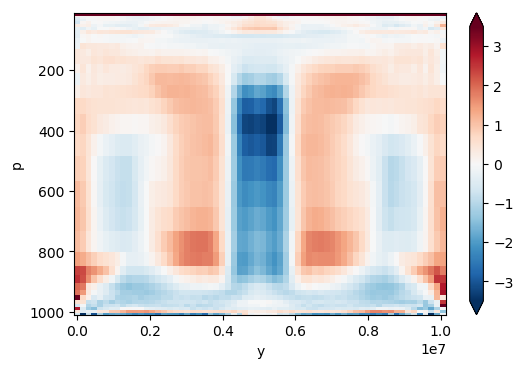

In [5]:
FSL.mean(['x', 'time']).plot(vmax=3.5)
plt.ylim([1010, 10])

(1010, 10)

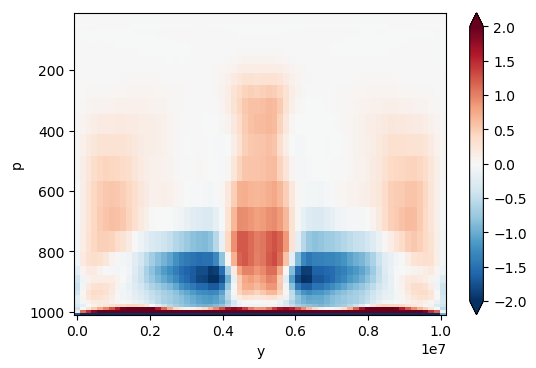

In [6]:
FQV.mean(['x', 'time']).plot(vmax=2)
plt.ylim([1010, 10])

How does this pattern compare to the forcings computed using advection terms?

In [7]:
ds_cent = xr.open_dataset(tend_path).assign(p=p).swap_dims({'z': 'p'})

(1010, 10)

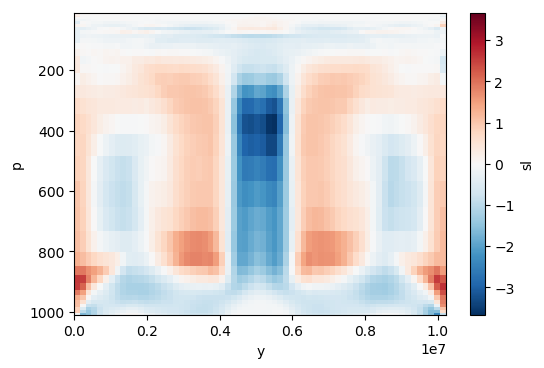

In [8]:
ds_cent.sl.mean(['x', 'time']).plot(x='y', y='p')
plt.ylim([1010, 10])

(1010, 10)

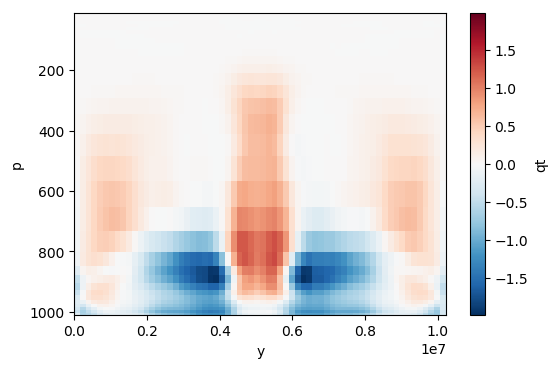

In [9]:
ds_cent.qt.mean(['x', 'time']).plot(x='y', y='p')
plt.ylim([1010, 10])

The means of these patterns are extremely similar. What about for one location

In [10]:
def plot_sl_loc(ds, **kwargs):
    ds.isel(x=0, y=50).plot(x='time', y='p', **kwargs)
    plt.ylim([1010, 10])
    plt.xlim([100, 120])

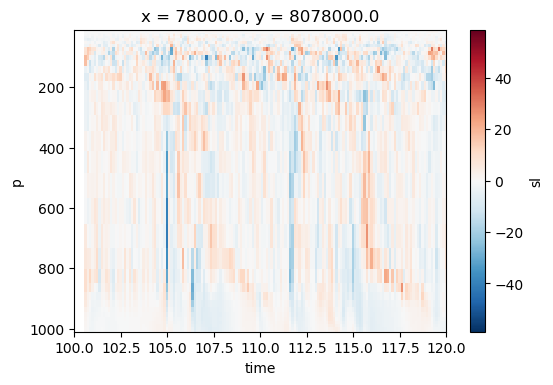

In [11]:
plot_sl_loc(ds_cent.sl)


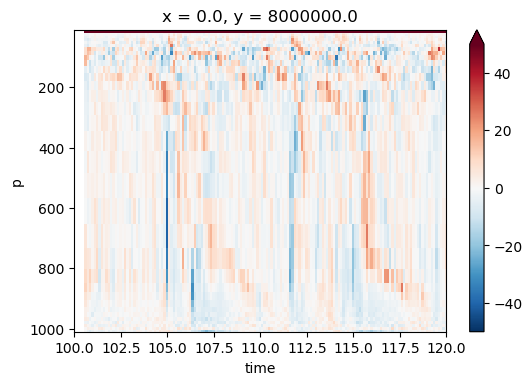

In [12]:
plot_sl_loc(FSL, vmax=50)

These forcings are so similar, it almost seems like there is no point to using the SAM-derived tendencies.

In [13]:
def prep(fsl, p=10, n=1000):
    np.random.seed(0)
    
    x = fsl.isel(p=p).values.ravel().clip(-50, 50)
    return np.random.choice(x, n)


def scatter_p(p=10):
    plt.scatter(prep(FSL, p=p), prep(ds_cent.sl, p=p), alpha=.5, s=.5)
    plt.xlabel('SAM Dry')
    plt.ylabel('Centered Differences')
    plt.title('p = %.2f'%FSL.p[p])

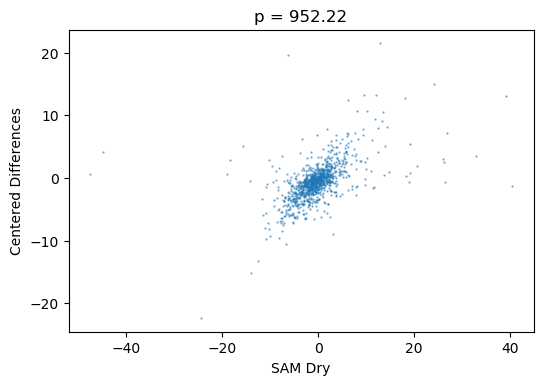

In [14]:
scatter_p(5)

Near the surface these values do not agree very well.

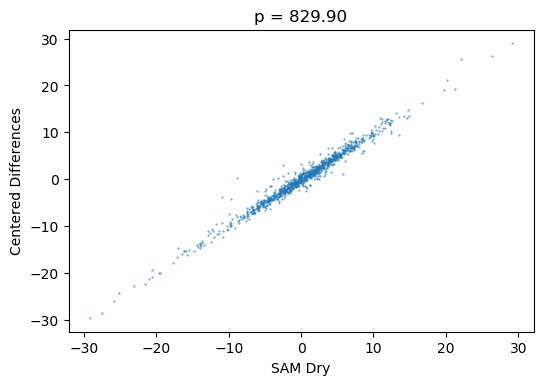

In [15]:
scatter_p(10)

In the mid troposphere they line up almost exactly.